## Introduction
** **
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

**To read more: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0**

** **
### LDA Implementation

1. [Loading data](#load_data)
2. [Data cleaning](#clean_data)
3. [Exploratory analysis](#eda)
4. [Prepare data for LDA analysis](#data_preparation)
5. [LDA model training](#train_model)
6. [Analyzing LDA model results](#results)

** **
For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **

In [1]:
# Importing modules
import pandas as pd
import os

# os.chdir('..')

# Read data into papers
papers = pd.read_csv('papers.csv')

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [2]:
len(papers)

6560

In [3]:
papers['symbols'] = papers['paper_text'].apply(lambda x: len(str(x)))
papers['symbols'].median()

28333.5

In [4]:
tmp_list = [x.split('\n') for x in papers.head()['paper_text'].values]

In [5]:
tmp_list

[['767',
  '',
  'SELF-ORGANIZATION OF ASSOCIATIVE DATABASE',
  'AND ITS APPLICATIONS',
  'Hisashi Suzuki and Suguru Arimoto',
  'Osaka University, Toyonaka, Osaka 560, Japan',
  'ABSTRACT',
  'An efficient method of self-organizing associative databases is proposed together with',
  'applications to robot eyesight systems. The proposed databases can associate any input',
  'with some output. In the first half part of discussion, an algorithm of self-organization is',
  'proposed. From an aspect of hardware, it produces a new style of neural network. In the',
  'latter half part, an applicability to handwritten letter recognition and that to an autonomous',
  'mobile robot system are demonstrated.',
  '',
  'INTRODUCTION',
  'Let a mapping f : X -+ Y be given. Here, X is a finite or infinite set, and Y is another',
  'finite or infinite set. A learning machine observes any set of pairs (x, y) sampled randomly',
  'from X x Y. (X x Y means the Cartesian product of X and Y.) And, it comp

** **
#### Step 2: Data Cleaning <a class="anchor\" id="clean_data"></a>
** **

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 100 papers

In [6]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(1000)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text,symbols
5301,1987,Analysis of Distributed Representation of Cons...,Abstract Missing,730\n\nAnalysis of distributed representation ...,35404
2171,2006,Learning to Rank with Nonsmooth Cost Functions,Abstract Missing,Learning to Rank with Nonsmooth Cost Functions...,30924
1229,1989,Time Dependent Adaptive Neural Networks,Abstract Missing,710\n\nPineda\n\nTime DependentAdaptive Neural...,22289
2251,2006,Statistical Modeling of Images with Fields of ...,Abstract Missing,Statistical Modeling of Images with\nFields of...,29856
2305,2006,iLSTD: Eligibility Traces and Convergence Anal...,Abstract Missing,iLSTD: Eligibility Traces and Convergence Anal...,26711


##### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of `paper_text` column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [7]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

5301    730\n\nanalysis of distributed representation ...
2171    learning to rank with nonsmooth cost functions...
1229    710\n\npineda\n\ntime dependentadaptive neural...
2251    statistical modeling of images with\nfields of...
2305    ilstd: eligibility traces and convergence anal...
Name: paper_text_processed, dtype: object

** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

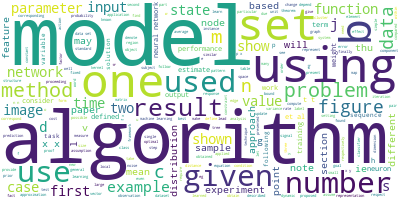

In [8]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [9]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Keller\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['analysis', 'distributed', 'representation', 'constituent', 'structure', 'connectionist', 'systems', 'paul', 'smolensky', 'department', 'computer', 'science', 'university', 'colorado', 'boulder', 'co', 'abstract', 'general', 'method', 'tensor', 'product', 'representation', 'described', 'distributed', 'representation', 'value', 'variable', 'bindings', 'method', 'allows']


In [10]:
import numpy as np
np.shape(data_words)

C:\Users\Keller\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(1000,)

In [11]:
data_words[0][0]

'analysis'

In [12]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0][:][:20])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 3), (7, 1), (8, 2), (9, 4), (10, 26), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1)]


In [13]:
print(np.shape(corpus[0]))
print(np.shape(data_words[0]))
print(np.shape(data_words))
print(np.shape(np.unique(data_words[0])))

(900, 2)
(2922,)
(1000,)
(900,)


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [14]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"model" + 0.006*"learning" + 0.005*"data" + 0.004*"function" + '
  '0.004*"set" + 0.004*"one" + 0.004*"using" + 0.004*"number" + 0.003*"figure" '
  '+ 0.003*"time"'),
 (1,
  '0.007*"learning" + 0.006*"model" + 0.006*"algorithm" + 0.006*"set" + '
  '0.005*"data" + 0.004*"number" + 0.004*"function" + 0.003*"using" + '
  '0.003*"time" + 0.003*"models"'),
 (2,
  '0.006*"model" + 0.006*"learning" + 0.005*"data" + 0.005*"using" + '
  '0.005*"algorithm" + 0.004*"matrix" + 0.004*"one" + 0.004*"function" + '
  '0.004*"set" + 0.004*"two"'),
 (3,
  '0.005*"model" + 0.005*"data" + 0.005*"algorithm" + 0.004*"learning" + '
  '0.004*"function" + 0.004*"problem" + 0.004*"using" + 0.004*"time" + '
  '0.003*"two" + 0.003*"also"'),
 (4,
  '0.007*"model" + 0.006*"data" + 0.005*"algorithm" + 0.005*"learning" + '
  '0.004*"using" + 0.004*"set" + 0.004*"figure" + 0.004*"function" + '
  '0.004*"one" + 0.004*"models"'),
 (5,
  '0.008*"learning" + 0.006*"model" + 0.006*"data" + 0.005*"algorithm" +

** **
#### Step 6: Analyzing our LDA model <a class="anchor\" id="results"></a>
** **

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [15]:
import pyLDAvis.gensim_models as gensimvis

In [16]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\Users\Keller\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.007118  0.000573       1        1  17.344911
9      0.001392 -0.001816       2        1  13.200734
5      0.000580 -0.001830       3        1  11.298552
3     -0.000324 -0.000664       4        1  10.863193
1      0.001140  0.003767       5        1  10.289710
6      0.000148 -0.001493       6        1   8.498948
7     -0.004713  0.003562       7        1   8.138272
4     -0.000822  0.002754       8        1   8.010393
0     -0.001722  0.000664       9        1   6.649390
8     -0.002794 -0.005517      10        1   5.705898, topic_info=          Term          Freq         Total Category  logprob  loglift
485      model  13848.000000  13848.000000  Default  30.0000  30.0000
426   learning  13966.000000  13966.000000  Default  29.0000  29.0000
729        set   9619.000000   9619.000000  Default  28.0000  28.0000
169       data  12580.000000  12580.000000  Default  27.0000  27.0000
319   function   9043.000000   9043.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1309    neural    296.569315   5347.990485  Topic10  -6.0881  -0.0285
478     method    264.482756   4854.069801  Topic10  -6.2026  -0.0461
62       based    272.084753   5612.950653  Topic10  -6.1743  -0.1630
507    network    267.943187   5757.054049  Topic10  -6.1896  -0.2037
299      first    264.362708   5286.088937  Topic10  -6.2031  -0.1318

[901 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
12214      1  0.208916  aaabbb
12214      7  0.208916  aaabbb
12214      8  0.208916  aaabbb
29041      1  0.149033   abuam
29041      3  0.149033   abuam
...      ...       ...     ...
27582      6  0.083335   zloop
27582      7  0.083335   zloop
27582      8  0.041668   zloop
27582      9  0.208338   zloop
27582     10  0.041668   zloop

[4330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 6, 4, 2, 7, 8, 5, 1, 9])

** **
#### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this article addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### References:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf
